<a href="https://colab.research.google.com/github/pauldamsa/Face-Recognition/blob/master/LFW_%26_FaceNet_performance_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import packages**

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Activation, Input, Add, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Concatenate, Lambda, add, GlobalAveragePooling2D, Convolution2D, LocallyConnected2D, ZeroPadding2D, concatenate, AveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)
import time
import os

import math
import copy

import cv2
import dlib

# **Load Data**

## Clone Repository

In [3]:
# It's necessary to clone this repository because it  contains the images
!git clone https://github.com/pauldamsa/Face-Recognition.git

Cloning into 'Face-Recognition'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 9550 (delta 7), reused 9 (delta 2), pack-reused 9531
Receiving objects: 100% (9550/9550), 171.86 MiB | 28.58 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Checking out files: 100% (6769/6769), done.


## Load Images

In [3]:
class Image:
  """
    This class will be used for mantaining informations about an image
  """
  def __init__(self, person_name):

    # Name of person
    self.person_name = person_name

    # A list with images of the person
    self.person_images = []

    # list of embeddings
    self.person_embeddings = None

    # a list of dicts with distances
    self.person_distances = None

    # reference images- a list 
    self.reference_embeddings = None

    # images with the faces of the person
    self.person_faces = None

    # number of ref images
    self.number_of_ref_images = 0
  
  def getPersonName(self):
    return self.person_name

  def getPersonImages(self):
    return self.person_images
  
  def setEmbeddings(self, embeddings):
    self.person_embeddings = embeddings
  
  def setDistances(self, distances):
    self.person_distances = distances

  def getReferenceEmbeddings(self):
    return self.reference_embeddings

  def setReferenceImages(self, number_of_ref_images):
    """
      This function is used of setting the ref embeddings for a person
    """
    self.number_of_ref_images = number_of_ref_images
    self.reference_embeddings = self.person_embeddings[:number_of_ref_images]
  
  def setPersonFaces(self, faces):
    self.person_faces = faces
  
  def getPersonFaces(self):
    return self.person_faces
  
  def getEmbeddings(self):
    return self.person_embeddings 
  
  def getDistances(self):
    return self.person_distances
  
  def getReferenceImages(self):
    return self.person_images[:self.number_of_ref_images]
  
  def addImage(self, image):
    """
      This function is used for adding an image with person to his/her list

      Arguments:
        image: the image we want to add (numpy array)
    """
    self.person_images.append(image)

def testImageClass():
  """
    This function is used for testing the Image class
  """
  img = Image("Paul")

  assert img.getPersonName() == "Paul"
  assert img.getPersonName() != "awd"
  assert len(img.getPersonImages()) == 0

  img.addImage(3)
  assert len(img.getPersonImages()) == 1

testImageClass()

class RepositoryImages:
  """
    This class will be used for storing the images
  """
  def __init__(self):

    # A dictionary in this form {name_of_person: Image(name_of_person, person_images) }
    self.images = {}

  def getAllImages(self):
    """
      This function is used for getting all images 

      Return:
        A list with all images from dict that contains Image objects
    """
    return list(self.images.values())
  
  def getAllImagesPersons(self):
    """
      This function is used for getting all images as a list

      Return:
        A list with all images of persons
    """
    imgs = []
    # Iterate through personalities
    for key_image in self.images.keys():
      imgs.append(self.images[key_image].getPersonImages())
    
    # Flat the imgs list because it is a list of lists
    flat_list = []
    for sublist in imgs:
        for item in sublist:
            flat_list.append(item)
    
    return flat_list
  
  def find(self, name_person):
    """
      This function is used for getting the images of a person

      Arguments:
        name_person: a string which represents the name of the person that we want to find
      
      Return:
        A object Image
    """
    return self.images[name_person]
  
  def read(self, path_to_dataset):
    """
      This function is used for reading the images from directories

      Arguments:
        path_to_dataset: the path where the images are stored
    """
    directories = os.listdir(path_to_dataset)

    self.images = {}
    print("Total directories: " +str(len(directories)))

    # Iterate thorugh directories of path_to_dataset directory
    for directory in directories:

      # Get the name of each directory
      name_of_images = os.listdir(path_to_dataset + directory)
      print("Current directory: " + directory + " " + str(len(name_of_images)))

      # Iterate through images
      for name_of_image in name_of_images:

        # If the image is already in dictionary
        if directory in self.images.keys():

          # Read the image
          image = cv2.imread(path_to_dataset + directory + "/" + name_of_image)

          # Add new image 
          self.images[directory].addImage(image)

        else:
          # Read the image
          image = Image(directory)
          image.addImage(cv2.imread(path_to_dataset + directory + "/" + name_of_image))
          self.images[directory] = image

def testRepository():
  assert len(repo.getAllImages()) == 2756

In [ ]:
# Create repository
repo = RepositoryImages()

path_to_dataset = "/content/Face-Recognition/lfw"
repo.read(path_to_dataset)

testRepository()

# **Display images**

## Declarations

In [18]:
class Service:
  """
    This class will be used for working with the while database of images
  """
  def __init__(self, repo):
    self.repo = repo
  
  def getAllImages(self):
    """
      This function is used for getting all images

      Return:
        A list with all images
    """
    return repo.getAllImages()

  def find(self, name_person):
    """
      This function is used for getting the images of a person

      Arguments:
        name_person: a string which represents the name of the person that we want to find
      
      Return:
        A object Image
    """
    return self.repo.find(name_person)
  
  def getAllImagesPersons(self):
    """
      This function is used for getting all images as a list

      Return:
        A list with all images of persons
    """
    return repo.getAllImagesPersons()
  
  def detectFacesOfPersons(self, face_detector):
    """
      This function will be used in order to get the faces of persons

      Arguments:
        face_detector: dlib face detector
    """

    # Get images
    images = self.getAllImages()

    # Iterate through personalities (Image Objects)
    for current_image in images:
      
      # Get images of current personality
      images_of_current_person = current_image.getPersonImages()

      # Init list of faces
      list_of_faces = []

      # Iterate through images of current personality
      for current_image_person in images_of_current_person:

        # Make the image gray
        image_gray = cv2.cvtColor(current_image_person, cv2.COLOR_RGB2GRAY)

        # Detect faces
        face_coord = face_detector(image_gray, 1)

        # If there was a face detected
        if len(face_coord) > 0:
          (x, y, w, h) = self.rect_to_bb(face_coord[0])
          x1, x2, y1, y2 = self.apply_offsets((x, y, w, h), (10, 10))

          # Crop the face
          image_face = current_image_person[y1:y2, x1:x2, :]

          image_face = np.asarray(image_face, dtype="float32")
          if image_face.shape[0] != 0 and image_face.shape[1] and image_face.shape[2] != 0:

            # Resize the image in (160, 160, 3)
            image_resized = cv2.resize(image_face, (160, 160), interpolation = cv2.INTER_AREA)

            # Normalize the pixels
            image_resized /= 255 

            # append current face to the list of faces
            list_of_faces.append(image_resized)
      
      # Set faces to the current image
      current_image.setPersonFaces(list_of_faces)
  
  def calculateEmbeddings(self, model):
    """
      This function is used for gettinf the embeddings of faces for each person

      Arguments:
        model: the model that will be used for predicting the embeddings
    """
    # Get all images objects
    images = self.getAllImages()

    # Iterate through objects
    for image in images:

      # Get current face images of personality
      current_faces_person = np.asarray(image.getPersonFaces(), dtype="float32")
      print(image.getPersonName() + " " + str(current_faces_person.shape))
      if current_faces_person.shape[0] != 0 and current_faces_person.shape[1] != 0 and current_faces_person.shape[2] != 0:
        # Get embeddings of current face
        current_embeddings = model.predict(current_faces_person, verbose = 0) # verbose = 0 means that we don't want to show the output
        
        # Set embeddings to the current image
        image.setEmbeddings(current_embeddings)
  
  def calculateDistances(self, name_of_person, number_of_ref_images):
    """
      This function is used in order to calculate the distance between a set of reference images and others

      Arguments:
        name_of_person: the name of the person that we want to get the distances
        number_of_ref_images: how many images we want to use as reference
    """
    # Init the list of dictionaries
    list_dist =[]
    # Get image of the person
    image_person = self.find(name_of_person)
    images = self.getAllImages()
    # Set reference images for person
    image_person.setReferenceImages(number_of_ref_images)

    # Get reference embeddings
    ref_embeddings = image_person.getReferenceEmbeddings()
    index = 0
    # Iterate through reference embeddings
    for current_ref_embeddings in ref_embeddings:
      print(index)
      # Init dictionary of distances
      dict_dist = {}

      # Iterate through all images
      for current_image in images:
        # Init list of distances
        list_distances = []

        # Get the current list of embeddings
        list_current_embeddings = current_image.getEmbeddings()
        # Iterate through embeddings of current image
        if len(current_image.getPersonFaces()) > 0:
          for current_image_embedding in list_current_embeddings:
            # Calculate the distance between current reference embeddings and current embeddings
            distance = self.findCosineDistance(current_ref_embeddings, current_image_embedding)

            # append to list of distances
            list_distances.append(distance)
        
          # Insert to dictionary the distances
          dict_dist[current_image.getPersonName()] = list_distances
    
      # Append to list the dictionary
      list_dist.append(dict_dist)

      # Update Index
      index += 1

    # Set the list of dist
    image_person.setDistances(list_dist)

  def make_flat(self,input_list):
    """
      input_list: a list of lists
    """
    flat_list = []
    for sublist in input_list:
        for item in sublist:
            flat_list.append(item)
    return flat_list
  
  def get_data_frame_of_person(self, name_person, threshold = 0.40):
    """
      This function will be used in order to get the dataframe with the performances of the model for a person

      Arguments:
        name_of_person: the name of the person that we want to get the distances
        threshold: the threshold we want to verify
      
      Return:
        A dataframe
    """
    # Init rows of dataframe
    rows = []
    
    # Get distances
    person = self.find(name_person)
    distances_of_person = person.getDistances()

    index = 0
    # Iterate through distances
    for current_dict_distances in distances_of_person:
      # get the list with all distances
      flat_list_distances = self.make_flat(current_dict_distances.values())
      current_list_dist_person = current_dict_distances[name_person]

      number_of_images_person = len(current_list_dist_person)
      total_faces = len(flat_list_distances) - number_of_images_person

      tp = len([x for x in current_list_dist_person if x <= threshold])
      percent_tp = round((tp * 100) / number_of_images_person,2)

      fn = number_of_images_person - tp
      percent_fn  = round(100 - percent_tp,2)
      
      fp = abs(len([x for x in flat_list_distances if x <= threshold]) - tp)
      percent_fp = round((fp * 100 )/ total_faces,2)

      row = [name_person + "_" +str(index), number_of_images_person, tp, percent_tp, fn, percent_fn, fp, total_faces, percent_fp]
      rows.append(row)
      index += 1

    # Create the dataframe
    df = pd.DataFrame(data = rows, columns=["Name", "Images of Name", "True Positives","Percent TP", "False Negatives", "Percent FN", "False positives","Total faces", "Percent FP"])
    
    return df

  def apply_offsets(self, face_coordinates, offsets):
    x, y, width, height = face_coordinates
    x_off, y_off = offsets
    return x - x_off, x + width + x_off, y - y_off, y + height + y_off

  def rect_to_bb(self, rect):
      x = rect.left()
      y = rect.top()
      w = rect.right() - x
      h = rect.bottom() - y

      return x, y, w, h

  def findCosineDistance(self, source_representation, test_representation):
    a = np.matmul(np.transpose(copy.deepcopy(source_representation)), copy.deepcopy(test_representation))
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))
  
  def displayFacesOfPerson(self, person_name):
    """
      This function is used for displaying the faces of a person

      Arguments:
        person_name: the name of the person that we want to see the faces
    """
    # Define the dimensions of the plot grid 
    list_of_images = self.find(person_name).getPersonFaces()
    dim = math.floor(math.sqrt(len(list_of_images)))
    W_grid = dim
    L_grid = dim

    # fig, axes = plt.subplots(L_grid, W_grid)
    # subplot return the figure object and axes object
    # we can use the axes object to plot specific figures at various locations

    fig, axes = plt.subplots(L_grid, W_grid, figsize = (25,25))

    axes = axes.ravel() 

    index = 0
    for i in np.arange(0, W_grid * L_grid):

        # read and display an image with the selected index    
        axes[i].imshow(np.int8(list_of_images[index]))
        axes[i].set_title(person_name + "_" + str(i))
        index+=1
        axes[i].axis('off')

    plt.subplots_adjust(hspace=0.4)
  
  def displayImages(self, number_of_images):
    """
      This function is used for displaying a number of images from dataset in a grid format

      Arguments:
        number_of_images: int which represents how many images
    """
    images = self.getAllImagesPersons()[:number_of_images]

    # Define the dimensions of the plot grid 
    W_grid = 10
    L_grid = 10

    # fig, axes = plt.subplots(L_grid, W_grid)
    # subplot return the figure object and axes object
    # we can use the axes object to plot specific figures at various locations

    fig, axes = plt.subplots(L_grid, W_grid, figsize = (25,25))

    axes = axes.ravel() 

    index = 0
    for i in np.arange(0, W_grid * L_grid):

        # read and display an image with the selected index    
        axes[i].imshow(cv2.cvtColor(np.uint8(images[index]), cv2.COLOR_BGR2RGB))
        index+=1
        axes[i].axis('off')

    plt.subplots_adjust(hspace=0.4)
  
  def displayImagesOfPerson(self, name_person):
    """
      This function is used for displaying the images of a person

      Arguments:
        name_person: a string which represents the name of a person that we want to see his/her images
    """
    # Define the dimensions of the plot grid 
    list_of_images = self.find(name_person).getPersonImages()
    dim = math.floor(math.sqrt(len(list_of_images)))
    W_grid = dim
    L_grid = dim

    # fig, axes = plt.subplots(L_grid, W_grid)
    # subplot return the figure object and axes object
    # we can use the axes object to plot specific figures at various locations

    fig, axes = plt.subplots(L_grid, W_grid, figsize = (25,25))

    axes = axes.ravel() 

    index = 0
    for i in np.arange(0, W_grid * L_grid):

        # read and display an image with the selected index    
        axes[i].imshow(cv2.cvtColor(np.uint8(list_of_images[index]), cv2.COLOR_BGR2RGB))
        axes[i].set_title(name_person + "_" + str(i))
        index+=1
        axes[i].axis('off')

    plt.subplots_adjust(hspace=0.4)
  
  def displayReferenceImagesOfPerson(self, name_person):
    """
      This function is used for displaying the reference images of a person

      Arguments:
        name_person: a string which represents the name of a person that we want to see his/her images
    """
    # Define the dimensions of the plot grid 
    list_of_images = self.find(name_person).getReferenceImages()
    dim = math.floor(math.sqrt(len(list_of_images)))
    W_grid = dim
    L_grid = dim

    # fig, axes = plt.subplots(L_grid, W_grid)
    # subplot return the figure object and axes object
    # we can use the axes object to plot specific figures at various locations

    fig, axes = plt.subplots(L_grid, W_grid, figsize = (25,25))

    axes = axes.ravel() 

    index = 0
    for i in np.arange(0, W_grid * L_grid):

        # read and display an image with the selected index    
        axes[i].imshow(cv2.cvtColor(np.uint8(list_of_images[index]), cv2.COLOR_BGR2RGB))
        axes[i].set_title(name_person + "_" + str(i))
        index+=1
        axes[i].axis('off')

    plt.subplots_adjust(hspace=0.4)

In [19]:
service = Service(repo=repo)

## Display first 100 images

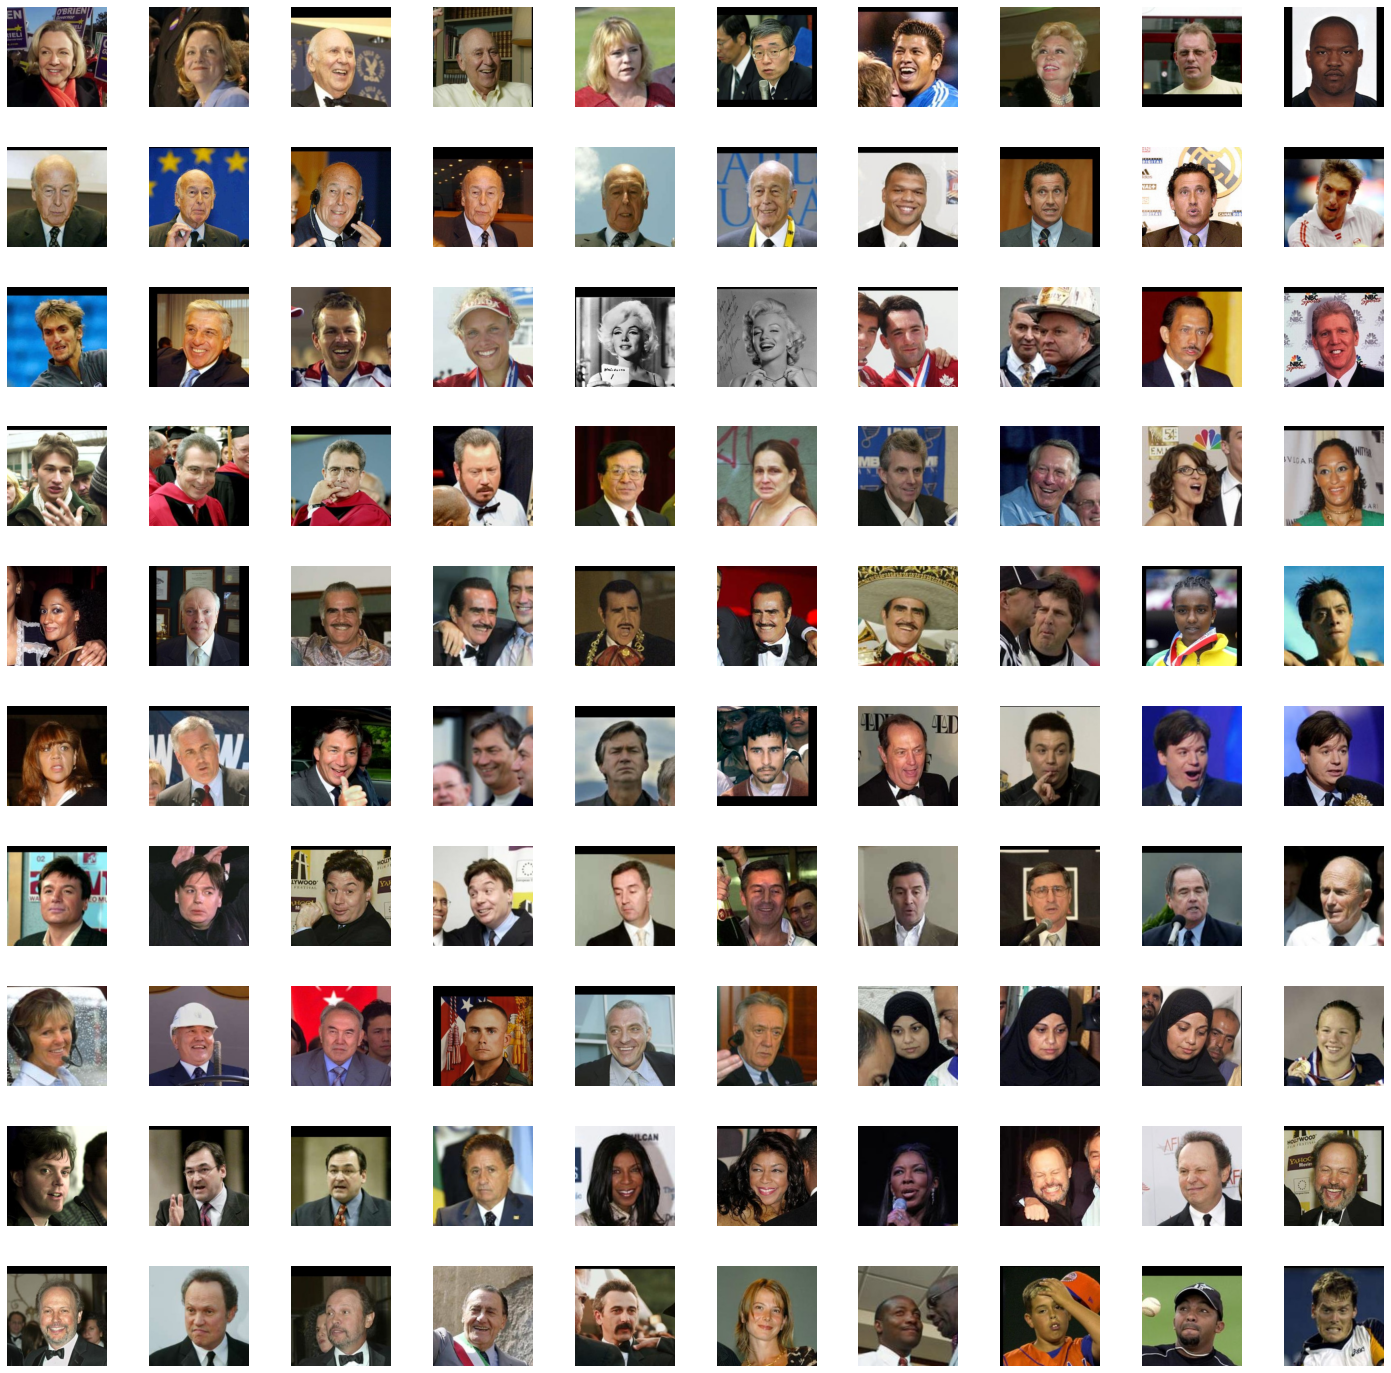

In [ ]:
service.displayImages(100)

## Display images with Tony Blair



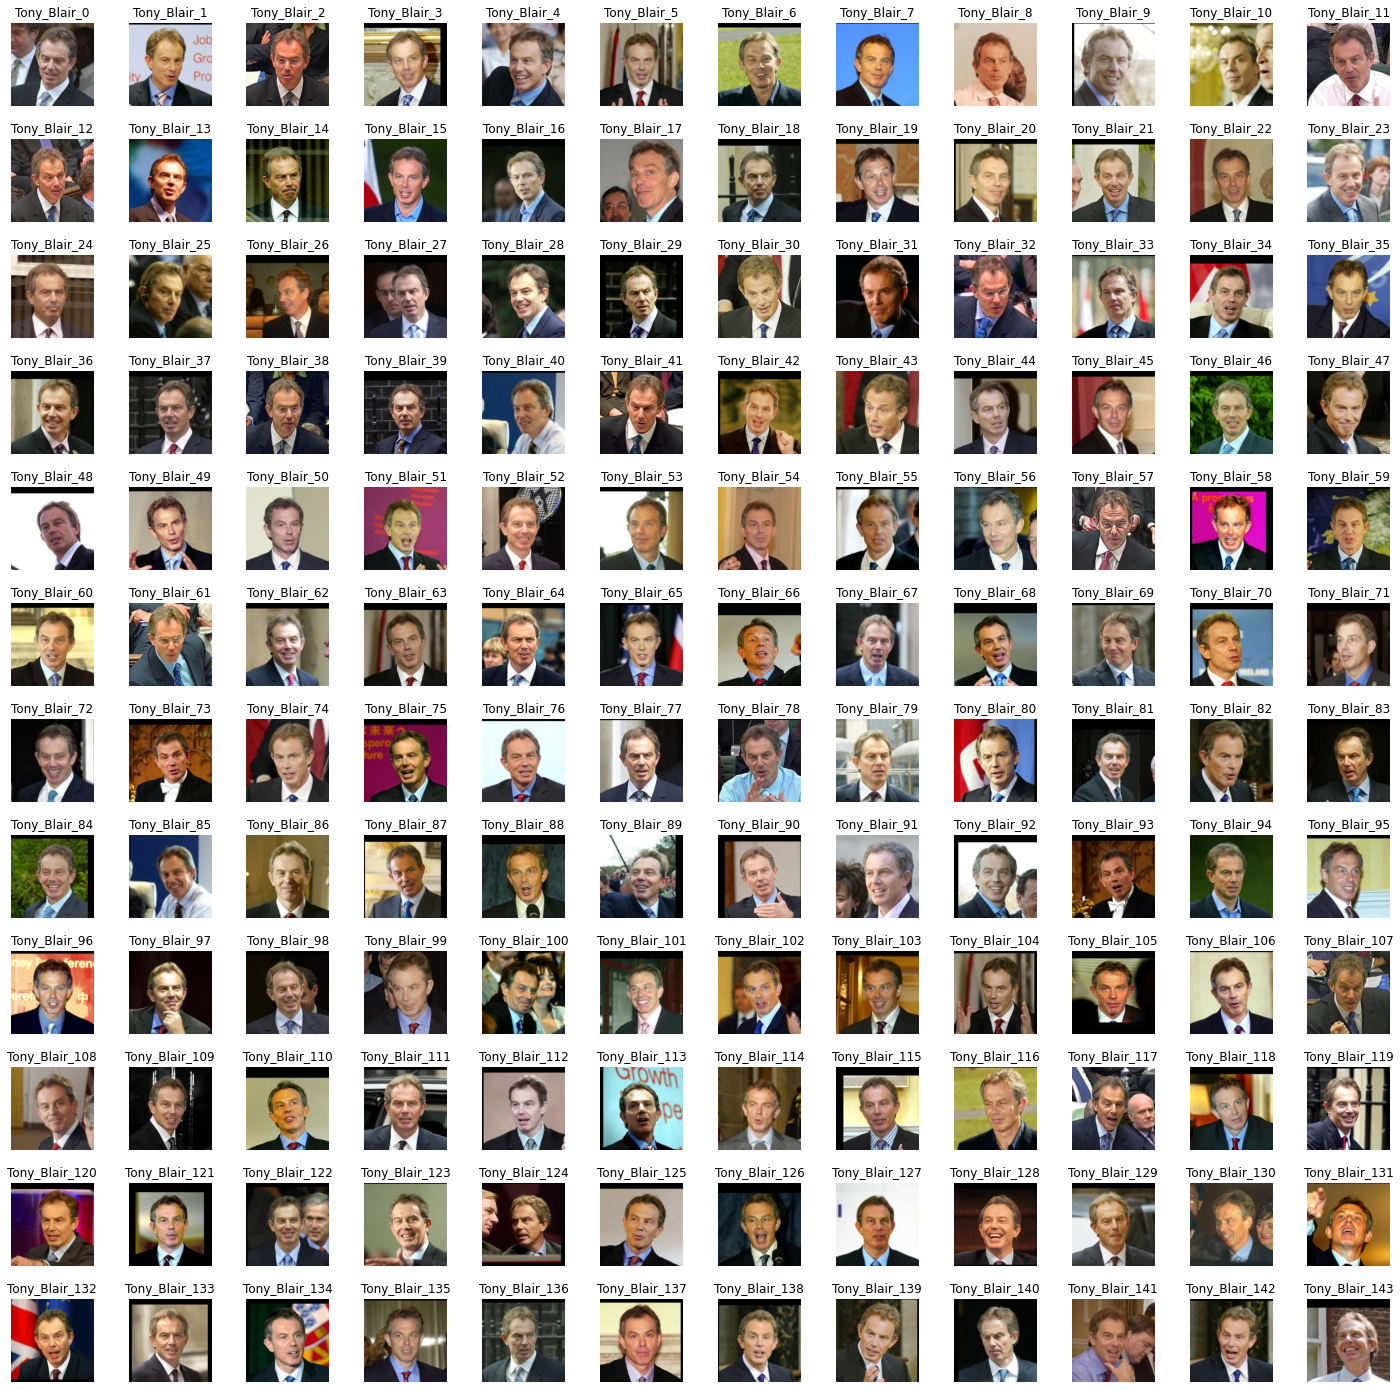

In [ ]:
service.displayImagesOfPerson("Tony_Blair")

# **Get Faces**

## Detect faces of persons

In [8]:
# This will take around 7min to finish
face_detector = dlib.get_frontal_face_detector()
service.detectFacesOfPersons(face_detector)

# **FaceNet**

In [9]:
def scaling(x, scale):
	return x * scale

def InceptionResNetV2():
	
	inputs = Input(shape=(160, 160, 3))
	x = Conv2D(32, 3, strides=2, padding='valid', use_bias=False, name= 'Conv2d_1a_3x3') (inputs)
	x = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Conv2d_1a_3x3_BatchNorm')(x)
	x = Activation('relu', name='Conv2d_1a_3x3_Activation')(x)
	x = Conv2D(32, 3, strides=1, padding='valid', use_bias=False, name= 'Conv2d_2a_3x3') (x)
	x = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Conv2d_2a_3x3_BatchNorm')(x)
	x = Activation('relu', name='Conv2d_2a_3x3_Activation')(x)
	x = Conv2D(64, 3, strides=1, padding='same', use_bias=False, name= 'Conv2d_2b_3x3') (x)
	x = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Conv2d_2b_3x3_BatchNorm')(x)
	x = Activation('relu', name='Conv2d_2b_3x3_Activation')(x)
	x = MaxPooling2D(3, strides=2, name='MaxPool_3a_3x3')(x)
	x = Conv2D(80, 1, strides=1, padding='valid', use_bias=False, name= 'Conv2d_3b_1x1') (x)
	x = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Conv2d_3b_1x1_BatchNorm')(x)
	x = Activation('relu', name='Conv2d_3b_1x1_Activation')(x)
	x = Conv2D(192, 3, strides=1, padding='valid', use_bias=False, name= 'Conv2d_4a_3x3') (x)
	x = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Conv2d_4a_3x3_BatchNorm')(x)
	x = Activation('relu', name='Conv2d_4a_3x3_Activation')(x)
	x = Conv2D(256, 3, strides=2, padding='valid', use_bias=False, name= 'Conv2d_4b_3x3') (x)
	x = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Conv2d_4b_3x3_BatchNorm')(x)
	x = Activation('relu', name='Conv2d_4b_3x3_Activation')(x)
	
	# 5x Block35 (Inception-ResNet-A block):
	branch_0 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_1_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_1_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block35_1_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_1_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_1_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_1_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_1_Branch_1_Conv2d_0b_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_1_Branch_1_Conv2d_0b_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_1_Branch_1_Conv2d_0b_3x3_Activation')(branch_1)
	branch_2 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_1_Branch_2_Conv2d_0a_1x1') (x)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_1_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_1_Branch_2_Conv2d_0a_1x1_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_1_Branch_2_Conv2d_0b_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_1_Branch_2_Conv2d_0b_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_1_Branch_2_Conv2d_0b_3x3_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_1_Branch_2_Conv2d_0c_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_1_Branch_2_Conv2d_0c_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_1_Branch_2_Conv2d_0c_3x3_Activation')(branch_2)
	branches = [branch_0, branch_1, branch_2]
	mixed = Concatenate(axis=3, name='Block35_1_Concatenate')(branches)
	up = Conv2D(256, 1, strides=1, padding='same', use_bias=True, name= 'Block35_1_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.17})(up)
	x = add([x, up])
	x = Activation('relu', name='Block35_1_Activation')(x)
	
	branch_0 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_2_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_2_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block35_2_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_2_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_2_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_2_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_2_Branch_1_Conv2d_0b_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_2_Branch_1_Conv2d_0b_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_2_Branch_1_Conv2d_0b_3x3_Activation')(branch_1)
	branch_2 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_2_Branch_2_Conv2d_0a_1x1') (x)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_2_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_2_Branch_2_Conv2d_0a_1x1_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_2_Branch_2_Conv2d_0b_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_2_Branch_2_Conv2d_0b_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_2_Branch_2_Conv2d_0b_3x3_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_2_Branch_2_Conv2d_0c_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_2_Branch_2_Conv2d_0c_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_2_Branch_2_Conv2d_0c_3x3_Activation')(branch_2)
	branches = [branch_0, branch_1, branch_2]
	mixed = Concatenate(axis=3, name='Block35_2_Concatenate')(branches)
	up = Conv2D(256, 1, strides=1, padding='same', use_bias=True, name= 'Block35_2_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.17})(up)
	x = add([x, up])
	x = Activation('relu', name='Block35_2_Activation')(x)
	
	branch_0 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_3_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_3_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block35_3_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_3_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_3_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_3_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_3_Branch_1_Conv2d_0b_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_3_Branch_1_Conv2d_0b_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_3_Branch_1_Conv2d_0b_3x3_Activation')(branch_1)
	branch_2 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_3_Branch_2_Conv2d_0a_1x1') (x)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_3_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_3_Branch_2_Conv2d_0a_1x1_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_3_Branch_2_Conv2d_0b_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_3_Branch_2_Conv2d_0b_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_3_Branch_2_Conv2d_0b_3x3_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_3_Branch_2_Conv2d_0c_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_3_Branch_2_Conv2d_0c_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_3_Branch_2_Conv2d_0c_3x3_Activation')(branch_2)
	branches = [branch_0, branch_1, branch_2]
	mixed = Concatenate(axis=3, name='Block35_3_Concatenate')(branches)
	up = Conv2D(256, 1, strides=1, padding='same', use_bias=True, name= 'Block35_3_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.17})(up)
	x = add([x, up])
	x = Activation('relu', name='Block35_3_Activation')(x)
	
	branch_0 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_4_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_4_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block35_4_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_4_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_4_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_4_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_4_Branch_1_Conv2d_0b_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_4_Branch_1_Conv2d_0b_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_4_Branch_1_Conv2d_0b_3x3_Activation')(branch_1)
	branch_2 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_4_Branch_2_Conv2d_0a_1x1') (x)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_4_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_4_Branch_2_Conv2d_0a_1x1_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_4_Branch_2_Conv2d_0b_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_4_Branch_2_Conv2d_0b_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_4_Branch_2_Conv2d_0b_3x3_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_4_Branch_2_Conv2d_0c_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_4_Branch_2_Conv2d_0c_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_4_Branch_2_Conv2d_0c_3x3_Activation')(branch_2)
	branches = [branch_0, branch_1, branch_2]
	mixed = Concatenate(axis=3, name='Block35_4_Concatenate')(branches)
	up = Conv2D(256, 1, strides=1, padding='same', use_bias=True, name= 'Block35_4_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.17})(up)
	x = add([x, up])
	x = Activation('relu', name='Block35_4_Activation')(x)
	
	branch_0 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_5_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_5_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block35_5_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_5_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_5_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_5_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_5_Branch_1_Conv2d_0b_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_5_Branch_1_Conv2d_0b_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_5_Branch_1_Conv2d_0b_3x3_Activation')(branch_1)
	branch_2 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_5_Branch_2_Conv2d_0a_1x1') (x)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_5_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_5_Branch_2_Conv2d_0a_1x1_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_5_Branch_2_Conv2d_0b_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_5_Branch_2_Conv2d_0b_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_5_Branch_2_Conv2d_0b_3x3_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_5_Branch_2_Conv2d_0c_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_5_Branch_2_Conv2d_0c_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_5_Branch_2_Conv2d_0c_3x3_Activation')(branch_2)
	branches = [branch_0, branch_1, branch_2]
	mixed = Concatenate(axis=3, name='Block35_5_Concatenate')(branches)
	up = Conv2D(256, 1, strides=1, padding='same', use_bias=True, name= 'Block35_5_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.17})(up)
	x = add([x, up])
	x = Activation('relu', name='Block35_5_Activation')(x)

	# Mixed 6a (Reduction-A block):
	branch_0 = Conv2D(384, 3, strides=2, padding='valid', use_bias=False, name= 'Mixed_6a_Branch_0_Conv2d_1a_3x3') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_6a_Branch_0_Conv2d_1a_3x3_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Mixed_6a_Branch_0_Conv2d_1a_3x3_Activation')(branch_0)
	branch_1 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Mixed_6a_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_6a_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Mixed_6a_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(192, 3, strides=1, padding='same', use_bias=False, name= 'Mixed_6a_Branch_1_Conv2d_0b_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_6a_Branch_1_Conv2d_0b_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Mixed_6a_Branch_1_Conv2d_0b_3x3_Activation')(branch_1)
	branch_1 = Conv2D(256, 3, strides=2, padding='valid', use_bias=False, name= 'Mixed_6a_Branch_1_Conv2d_1a_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_6a_Branch_1_Conv2d_1a_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Mixed_6a_Branch_1_Conv2d_1a_3x3_Activation')(branch_1)
	branch_pool = MaxPooling2D(3, strides=2, padding='valid', name='Mixed_6a_Branch_2_MaxPool_1a_3x3')(x)
	branches = [branch_0, branch_1, branch_pool]
	x = Concatenate(axis=3, name='Mixed_6a')(branches)

	# 10x Block17 (Inception-ResNet-B block):
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_1_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_1_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_1_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_1_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_1_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_1_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_1_Branch_1_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_1_Branch_1_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_1_Branch_1_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_1_Branch_1_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_1_Branch_1_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_1_Branch_1_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_1_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_1_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_1_Activation')(x)
	
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_2_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_2_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_2_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_2_Branch_2_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_2_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_2_Branch_2_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_2_Branch_2_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_2_Branch_2_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_2_Branch_2_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_2_Branch_2_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_2_Branch_2_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_2_Branch_2_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_2_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_2_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_2_Activation')(x)
	
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_3_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_3_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_3_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_3_Branch_3_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_3_Branch_3_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_3_Branch_3_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_3_Branch_3_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_3_Branch_3_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_3_Branch_3_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_3_Branch_3_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_3_Branch_3_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_3_Branch_3_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_3_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_3_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_3_Activation')(x)
	
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_4_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_4_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_4_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_4_Branch_4_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_4_Branch_4_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_4_Branch_4_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_4_Branch_4_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_4_Branch_4_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_4_Branch_4_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_4_Branch_4_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_4_Branch_4_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_4_Branch_4_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_4_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_4_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_4_Activation')(x)
	
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_5_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_5_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_5_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_5_Branch_5_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_5_Branch_5_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_5_Branch_5_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_5_Branch_5_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_5_Branch_5_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_5_Branch_5_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_5_Branch_5_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_5_Branch_5_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_5_Branch_5_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_5_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_5_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_5_Activation')(x)
	
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_6_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_6_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_6_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_6_Branch_6_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_6_Branch_6_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_6_Branch_6_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_6_Branch_6_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_6_Branch_6_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_6_Branch_6_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_6_Branch_6_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_6_Branch_6_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_6_Branch_6_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_6_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_6_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_6_Activation')(x)	
	
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_7_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_7_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_7_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_7_Branch_7_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_7_Branch_7_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_7_Branch_7_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_7_Branch_7_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_7_Branch_7_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_7_Branch_7_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_7_Branch_7_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_7_Branch_7_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_7_Branch_7_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_7_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_7_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_7_Activation')(x)
	
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_8_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_8_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_8_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_8_Branch_8_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_8_Branch_8_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_8_Branch_8_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_8_Branch_8_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_8_Branch_8_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_8_Branch_8_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_8_Branch_8_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_8_Branch_8_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_8_Branch_8_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_8_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_8_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_8_Activation')(x)
	
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_9_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_9_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_9_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_9_Branch_9_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_9_Branch_9_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_9_Branch_9_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_9_Branch_9_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_9_Branch_9_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_9_Branch_9_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_9_Branch_9_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_9_Branch_9_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_9_Branch_9_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_9_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_9_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_9_Activation')(x)
	
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_10_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_10_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_10_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_10_Branch_10_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_10_Branch_10_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_10_Branch_10_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_10_Branch_10_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_10_Branch_10_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_10_Branch_10_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_10_Branch_10_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_10_Branch_10_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_10_Branch_10_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_10_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_10_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_10_Activation')(x)

	# Mixed 7a (Reduction-B block): 8 x 8 x 2080	
	branch_0 = Conv2D(256, 1, strides=1, padding='same', use_bias=False, name= 'Mixed_7a_Branch_0_Conv2d_0a_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_7a_Branch_0_Conv2d_0a_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Mixed_7a_Branch_0_Conv2d_0a_1x1_Activation')(branch_0)
	branch_0 = Conv2D(384, 3, strides=2, padding='valid', use_bias=False, name= 'Mixed_7a_Branch_0_Conv2d_1a_3x3') (branch_0)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_7a_Branch_0_Conv2d_1a_3x3_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Mixed_7a_Branch_0_Conv2d_1a_3x3_Activation')(branch_0)
	branch_1 = Conv2D(256, 1, strides=1, padding='same', use_bias=False, name= 'Mixed_7a_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_7a_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Mixed_7a_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(256, 3, strides=2, padding='valid', use_bias=False, name= 'Mixed_7a_Branch_1_Conv2d_1a_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_7a_Branch_1_Conv2d_1a_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Mixed_7a_Branch_1_Conv2d_1a_3x3_Activation')(branch_1)
	branch_2 = Conv2D(256, 1, strides=1, padding='same', use_bias=False, name= 'Mixed_7a_Branch_2_Conv2d_0a_1x1') (x)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_7a_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Mixed_7a_Branch_2_Conv2d_0a_1x1_Activation')(branch_2)
	branch_2 = Conv2D(256, 3, strides=1, padding='same', use_bias=False, name= 'Mixed_7a_Branch_2_Conv2d_0b_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_7a_Branch_2_Conv2d_0b_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Mixed_7a_Branch_2_Conv2d_0b_3x3_Activation')(branch_2)
	branch_2 = Conv2D(256, 3, strides=2, padding='valid', use_bias=False, name= 'Mixed_7a_Branch_2_Conv2d_1a_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_7a_Branch_2_Conv2d_1a_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Mixed_7a_Branch_2_Conv2d_1a_3x3_Activation')(branch_2)
	branch_pool = MaxPooling2D(3, strides=2, padding='valid', name='Mixed_7a_Branch_3_MaxPool_1a_3x3')(x)
	branches = [branch_0, branch_1, branch_2, branch_pool]
	x = Concatenate(axis=3, name='Mixed_7a')(branches)

	# 5x Block8 (Inception-ResNet-C block):
	
	branch_0 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_1_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_1_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block8_1_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_1_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_1_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_1_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(192, [1, 3], strides=1, padding='same', use_bias=False, name= 'Block8_1_Branch_1_Conv2d_0b_1x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_1_Branch_1_Conv2d_0b_1x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_1_Branch_1_Conv2d_0b_1x3_Activation')(branch_1)
	branch_1 = Conv2D(192, [3, 1], strides=1, padding='same', use_bias=False, name= 'Block8_1_Branch_1_Conv2d_0c_3x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_1_Branch_1_Conv2d_0c_3x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_1_Branch_1_Conv2d_0c_3x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block8_1_Concatenate')(branches)
	up = Conv2D(1792, 1, strides=1, padding='same', use_bias=True, name= 'Block8_1_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.2})(up)
	x = add([x, up])
	x = Activation('relu', name='Block8_1_Activation')(x)
	
	branch_0 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_2_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_2_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block8_2_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_2_Branch_2_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_2_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_2_Branch_2_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(192, [1, 3], strides=1, padding='same', use_bias=False, name= 'Block8_2_Branch_2_Conv2d_0b_1x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_2_Branch_2_Conv2d_0b_1x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_2_Branch_2_Conv2d_0b_1x3_Activation')(branch_1)
	branch_1 = Conv2D(192, [3, 1], strides=1, padding='same', use_bias=False, name= 'Block8_2_Branch_2_Conv2d_0c_3x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_2_Branch_2_Conv2d_0c_3x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_2_Branch_2_Conv2d_0c_3x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block8_2_Concatenate')(branches)
	up = Conv2D(1792, 1, strides=1, padding='same', use_bias=True, name= 'Block8_2_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.2})(up)
	x = add([x, up])
	x = Activation('relu', name='Block8_2_Activation')(x)
	
	branch_0 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_3_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_3_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block8_3_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_3_Branch_3_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_3_Branch_3_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_3_Branch_3_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(192, [1, 3], strides=1, padding='same', use_bias=False, name= 'Block8_3_Branch_3_Conv2d_0b_1x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_3_Branch_3_Conv2d_0b_1x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_3_Branch_3_Conv2d_0b_1x3_Activation')(branch_1)
	branch_1 = Conv2D(192, [3, 1], strides=1, padding='same', use_bias=False, name= 'Block8_3_Branch_3_Conv2d_0c_3x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_3_Branch_3_Conv2d_0c_3x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_3_Branch_3_Conv2d_0c_3x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block8_3_Concatenate')(branches)
	up = Conv2D(1792, 1, strides=1, padding='same', use_bias=True, name= 'Block8_3_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.2})(up)
	x = add([x, up])
	x = Activation('relu', name='Block8_3_Activation')(x)
	
	branch_0 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_4_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_4_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block8_4_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_4_Branch_4_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_4_Branch_4_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_4_Branch_4_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(192, [1, 3], strides=1, padding='same', use_bias=False, name= 'Block8_4_Branch_4_Conv2d_0b_1x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_4_Branch_4_Conv2d_0b_1x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_4_Branch_4_Conv2d_0b_1x3_Activation')(branch_1)
	branch_1 = Conv2D(192, [3, 1], strides=1, padding='same', use_bias=False, name= 'Block8_4_Branch_4_Conv2d_0c_3x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_4_Branch_4_Conv2d_0c_3x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_4_Branch_4_Conv2d_0c_3x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block8_4_Concatenate')(branches)
	up = Conv2D(1792, 1, strides=1, padding='same', use_bias=True, name= 'Block8_4_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.2})(up)
	x = add([x, up])
	x = Activation('relu', name='Block8_4_Activation')(x)
	
	branch_0 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_5_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_5_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block8_5_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_5_Branch_5_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_5_Branch_5_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_5_Branch_5_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(192, [1, 3], strides=1, padding='same', use_bias=False, name= 'Block8_5_Branch_5_Conv2d_0b_1x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_5_Branch_5_Conv2d_0b_1x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_5_Branch_5_Conv2d_0b_1x3_Activation')(branch_1)
	branch_1 = Conv2D(192, [3, 1], strides=1, padding='same', use_bias=False, name= 'Block8_5_Branch_5_Conv2d_0c_3x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_5_Branch_5_Conv2d_0c_3x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_5_Branch_5_Conv2d_0c_3x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block8_5_Concatenate')(branches)
	up = Conv2D(1792, 1, strides=1, padding='same', use_bias=True, name= 'Block8_5_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.2})(up)
	x = add([x, up])
	x = Activation('relu', name='Block8_5_Activation')(x)
	
	branch_0 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_6_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_6_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block8_6_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_6_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_6_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_6_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(192, [1, 3], strides=1, padding='same', use_bias=False, name= 'Block8_6_Branch_1_Conv2d_0b_1x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_6_Branch_1_Conv2d_0b_1x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_6_Branch_1_Conv2d_0b_1x3_Activation')(branch_1)
	branch_1 = Conv2D(192, [3, 1], strides=1, padding='same', use_bias=False, name= 'Block8_6_Branch_1_Conv2d_0c_3x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_6_Branch_1_Conv2d_0c_3x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_6_Branch_1_Conv2d_0c_3x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block8_6_Concatenate')(branches)
	up = Conv2D(1792, 1, strides=1, padding='same', use_bias=True, name= 'Block8_6_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 1})(up)
	x = add([x, up])
	
	# Classification block
	x = GlobalAveragePooling2D(name='AvgPool')(x)
	x = Dropout(1.0 - 0.8, name='Dropout')(x)
	# Bottleneck
	x = Dense(128, use_bias=False, name='Bottleneck')(x)
	x = BatchNormalization(momentum=0.995, epsilon=0.001, scale=False, name='Bottleneck_BatchNorm')(x)

	# Create model
	model = Model(inputs, x, name='inception_resnet_v1')

	return model

# Create the FaceNet model
FaceNetModel = InceptionResNetV2()

# Load the weights of the model
path = "/content/Face-Recognition/facenet_weights.h5"
FaceNetModel.load_weights(path)

# **Analysis of distances**

## Calculate embeddings

In [ ]:
# This will take around 5min. to finish
images_embeddings = service.calculateEmbeddings(FaceNetModel)

## Calculate distances between ref_imgs and other for a personality

In [ ]:
person_name = "Tony_Blair"
number_of_ref_imgs = 144

service.calculateDistances(person_name, number_of_ref_imgs)

**Display DataFrame of a person**

In [33]:
df_person = service.get_data_frame_of_person(person_name)

In [34]:
df_person.sort_values(by="Percent TP",ascending=False, ignore_index=True)

Name  Images of Name  ...  Total faces  Percent FP
0     Tony_Blair_98             144  ...         6544        0.12
1     Tony_Blair_11             144  ...         6544        0.12
2     Tony_Blair_44             144  ...         6544        0.15
3     Tony_Blair_94             144  ...         6544        0.02
4     Tony_Blair_37             144  ...         6544        0.18
5    Tony_Blair_115             144  ...         6544        0.15
6    Tony_Blair_141             144  ...         6544        0.20
7    Tony_Blair_134             144  ...         6544        0.03
8     Tony_Blair_34             144  ...         6544        0.08
9    Tony_Blair_136             144  ...         6544        0.14
10    Tony_Blair_46             144  ...         6544        0.08
11    Tony_Blair_16             144  ...         6544        0.12
12     Tony_Blair_8             144  ...         6544        0.14
13    Tony_Blair_68             144  ...         6544        0.44
14    Tony_Blair_20             144  ...         6544        0.17
15   Tony_Blair_111             144  ...         6544        0.08
16    Tony_Blair_92             144  ...         6544        0.14
17    Tony_Blair_60             144  ...         6544        0.17
18    Tony_Blair_62             144  ...         6544        0.14
19    Tony_Blair_90             144  ...         6544        0.37
20    Tony_Blair_79             144  ...         6544        0.05
21   Tony_Blair_122             144  ...         6544        0.05
22    Tony_Blair_76             144  ...         6544        0.03
23   Tony_Blair_103             144  ...         6544        0.18
24   Tony_Blair_132             144  ...         6544        0.06
25     Tony_Blair_7             144  ...         6544        0.09
26    Tony_Blair_21             144  ...         6544        0.06
27    Tony_Blair_27             144  ...         6544        0.06
28    Tony_Blair_78             144  ...         6544        0.15
29    Tony_Blair_55             144  ...         6544        0.15
30    Tony_Blair_72             144  ...         6544        0.20
31   Tony_Blair_120             144  ...         6544        0.03
32   Tony_Blair_138             144  ...         6544        0.03
33    Tony_Blair_84             144  ...         6544        0.03
34    Tony_Blair_10             144  ...         6544        0.06
35   Tony_Blair_109             144  ...         6544        0.11
36    Tony_Blair_99             144  ...         6544        0.09
37   Tony_Blair_142             144  ...         6544        0.17
38    Tony_Blair_53             144  ...         6544        0.05
39    Tony_Blair_18             144  ...         6544        0.03
40   Tony_Blair_112             144  ...         6544        0.03
41    Tony_Blair_81             144  ...         6544        0.02
42    Tony_Blair_25             144  ...         6544        0.05
43   Tony_Blair_127             144  ...         6544        0.03
44    Tony_Blair_39             144  ...         6544        0.03
45     Tony_Blair_0             144  ...         6544        0.11
46     Tony_Blair_3             144  ...         6544        0.09
47    Tony_Blair_70             144  ...         6544        0.03
48    Tony_Blair_63             144  ...         6544        0.12
49    Tony_Blair_74             144  ...         6544        0.03
50   Tony_Blair_125             144  ...         6544        0.02
51    Tony_Blair_65             144  ...         6544        0.06
52     Tony_Blair_5             144  ...         6544        0.03
53    Tony_Blair_95             144  ...         6544        0.17
54   Tony_Blair_106             144  ...         6544        0.03
55   Tony_Blair_116             144  ...         6544        0.03
56   Tony_Blair_133             144  ...         6544        0.06
57    Tony_Blair_12             144  ...         6544        0.32
58    Tony_Blair_15             144  ...         6544        0.06
59    Tony_Blair_42             144  ...         6544  

**Display reference images of a person**

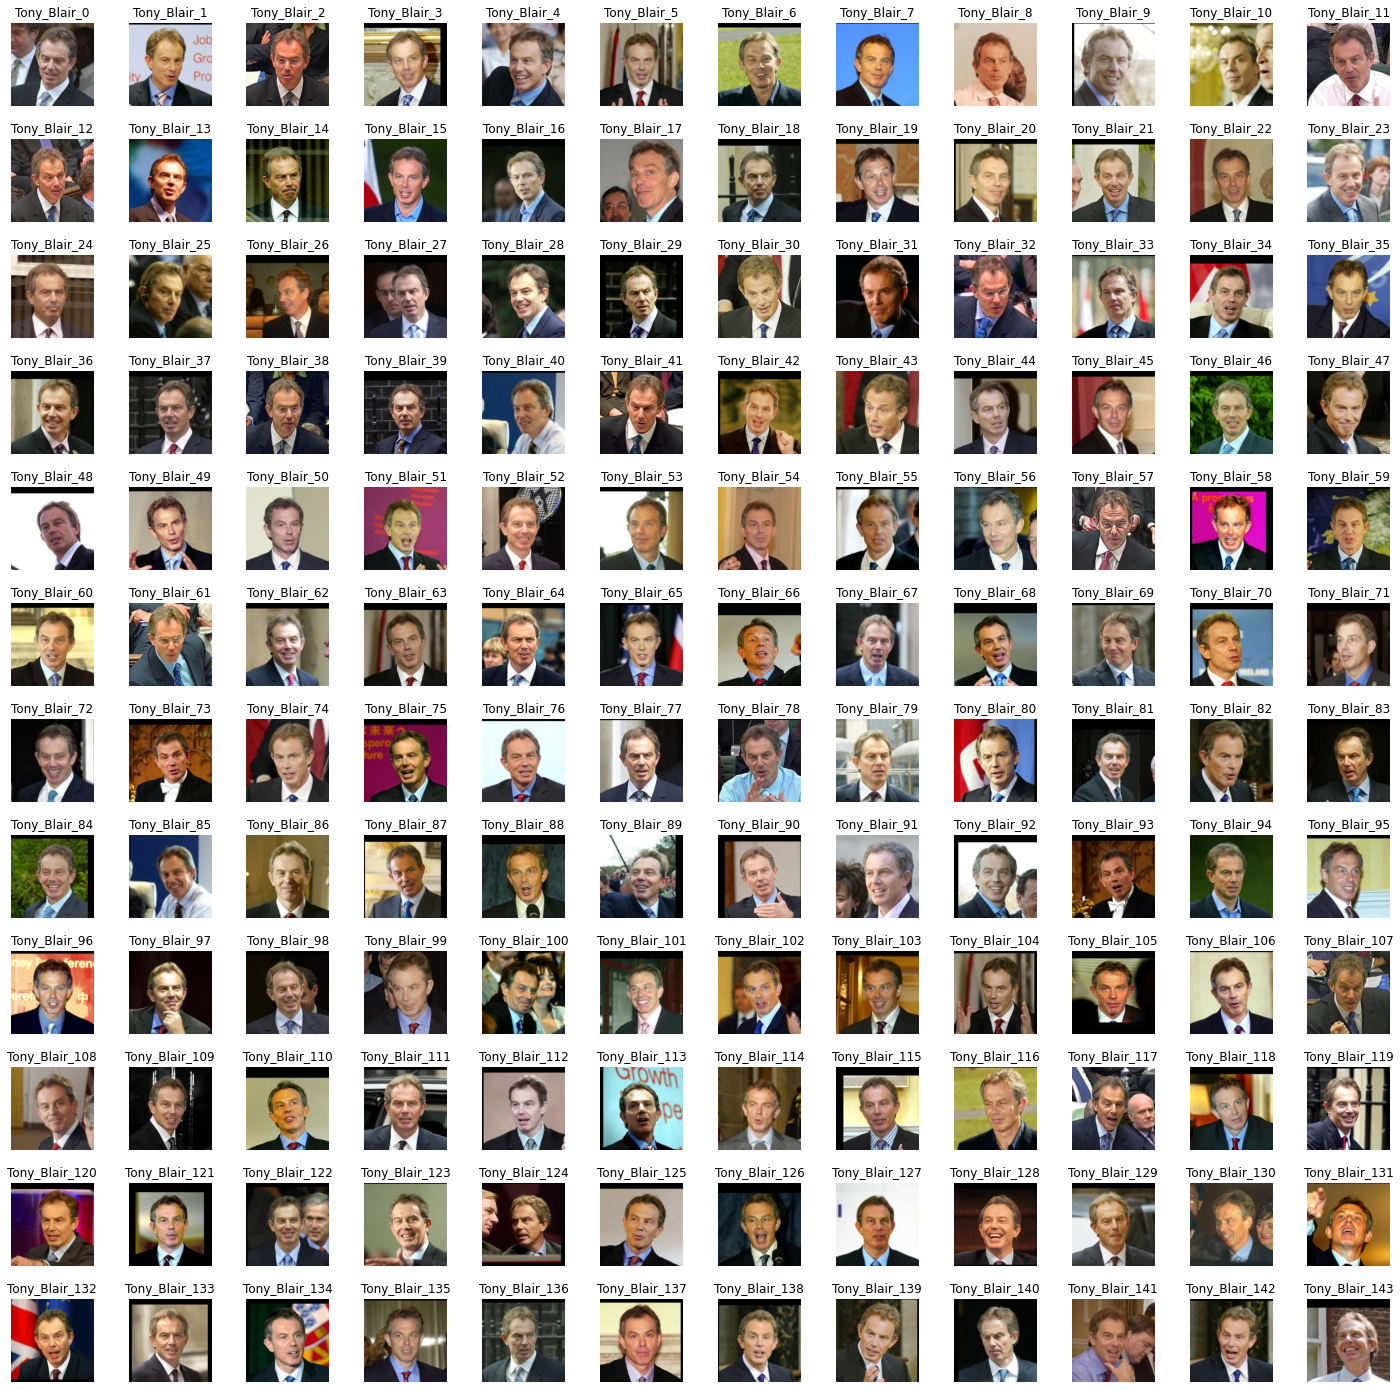

In [35]:
service.displayReferenceImagesOfPerson(person_name)

# **General Report**

In [10]:
df = pd.read_csv("/content/Face-Recognition/performance_facenet_lfw.csv")

In [11]:
# Correct the table
for i in range(len(df)):
  df.at[i, 'Total faces'] = df.iloc[i]['Total faces'] - df.iloc[i]['Images of Name']
  df.at[i, 'Percent FP'] = round((df.iloc[i]['False positives'] * 100) / (df.iloc[i]['Total faces']), 2)

In [13]:
# For this table the reference image for each personlaity was the first one
df.sort_values(by="Images of Name",ascending=False, ignore_index=True).head(50)

Name  Images of Name  ...  Total faces  Percent FP
0           George_W_Bush             526  ...         6162        0.19
1              Tony_Blair             144  ...         6544        0.11
2       Gerhard_Schroeder             108  ...         6580        0.24
3       Junichiro_Koizumi              60  ...         6628        0.03
4         Serena_Williams              52  ...         6636        0.09
5          Vladimir_Putin              47  ...         6641        0.12
6       Jennifer_Capriati              41  ...         6647        0.05
7              Laura_Bush              41  ...         6647        0.00
8               Hans_Blix              39  ...         6649        0.62
9        Alejandro_Toledo              39  ...         6649        0.00
10           Andre_Agassi              36  ...         6652        0.02
11        Nestor_Kirchner              36  ...         6652        0.08
12           Alvaro_Uribe              35  ...         6653        0.12
13      Silvio_Berlusconi              33  ...         6655        0.03
14              Tom_Ridge              33  ...         6655        0.11
15             Kofi_Annan              32  ...         6656        0.36
16  Megawati_Sukarnoputri              32  ...         6656        0.06
17            Vicente_Fox              31  ...         6657        0.23
18    Juan_Carlos_Ferrero              28  ...         6660        0.00
19           Bill_Clinton              28  ...         6660        0.15
20            Tom_Daschle              25  ...         6663        0.11
21      Jeremy_Greenstock              24  ...         6664        0.15
22       Rudolph_Giuliani              24  ...         6664        0.00
23           Winona_Ryder              24  ...         6664        0.02
24       Jose_Maria_Aznar              23  ...         6665        0.00
25            Tiger_Woods              23  ...         6665        0.00
26            Naomi_Watts              22  ...         6666        0.06
27           Hamid_Karzai              22  ...         6666        0.00
28       George_Robertson              22  ...         6666        0.00
29           Pete_Sampras              22  ...         6666        0.00
30           Carlos_Menem              21  ...         6667        0.10
31       Jennifer_Aniston              21  ...         6667        0.06
32         Jennifer_Lopez              21  ...         6667        0.00
33      Michael_Bloomberg              20  ...         6668        0.37
34         Angelina_Jolie              20  ...         6668        0.00
35        Amelie_Mauresmo              20  ...         6668        0.03
36             Tim_Henman              19  ...         6669        0.03
37         Julianne_Moore              19  ...         6669        0.00
38            Carlos_Moya              19  ...         6669        0.00
39            Paul_Bremer              19  ...         6669        0.66
40        Joschka_Fischer              19  ...         6669        0.01
41          Nicole_Kidman              19  ...         6669        0.06
42           Fidel_Castro              18  ...         6670        0.03
43        Lance_Armstrong              18  ...         6670        0.00
44        Spencer_Abraham              17  ...         6671        0.06
45     Michael_Schumacher              17  ...         6671        0.10
46             Bill_Gates              17  ...         6671        0.15
47            Halle_Berry              16  ...         6672        0.00
48           Tommy_Franks              16  ...         6672        0.07
49             Trent_Lott              16  ...         6672        0.10

[50 rows x 9 columns]

In [14]:
df.describe()

Images of Name  True Positives  ...  Total faces   Percent FP
count     2727.000000     2727.000000  ...  2727.000000  2727.000000
mean         2.452512        2.085075  ...  6685.547488     0.083198
std         11.285978       10.490087  ...    11.285978     0.151816
min          1.000000        1.000000  ...  6162.000000     0.000000
25%          1.000000        1.000000  ...  6686.000000     0.010000
50%          1.000000        1.000000  ...  6687.000000     0.030000
75%          2.000000        1.000000  ...  6687.000000     0.090000
max        526.000000      509.000000  ...  6687.000000     2.440000

[8 rows x 8 columns]